In [1]:
import pickle
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from warnings import filterwarnings
filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# unpikling
with open("../data/calibrator_data/data_inn2_model1.pkl", "rb") as f:
    data = pickle.load(f)

with open("../models/model_for_calibration/gradient_boosting_inn2_model1.bin", "rb") as m:
    model = pickle.load(m)


In [3]:
# getting data
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']
min_scaler = data['min_scaler']
std_scaler = data['std_scaler']
encoder = data['encoder']


# transforming data
numerical_cols = std_scaler.transform(
X_train.select_dtypes(exclude='object')
)

categorical_cols = encoder.transform(
X_train.select_dtypes(include='object')
)

X_train_scaled = np.hstack(
    (numerical_cols,categorical_cols)
)

# val_scaled
numerical_cols_ = std_scaler.transform(
    X_val.select_dtypes(exclude='object')
)
categorical_cols_ = encoder.transform(
    X_val.select_dtypes(include='object')
)

X_val_scaled = np.hstack(
    (numerical_cols_,categorical_cols_)
)

numerical_cols_ = std_scaler.transform(
    X_test.select_dtypes(exclude='object')
)
categorical_cols_ = encoder.transform(
    X_test.select_dtypes(include='object')
)

X_test_scaled = np.hstack(
    (numerical_cols_,categorical_cols_)
)

In [4]:
pred_probs_train = model.predict_proba(X_train_scaled)[:,1]
pred_probs_test = model.predict_proba(X_test_scaled)[:,1]
pred_probs_valid = model.predict_proba(X_val_scaled)[:,1]

<AxesSubplot: ylabel='Density'>

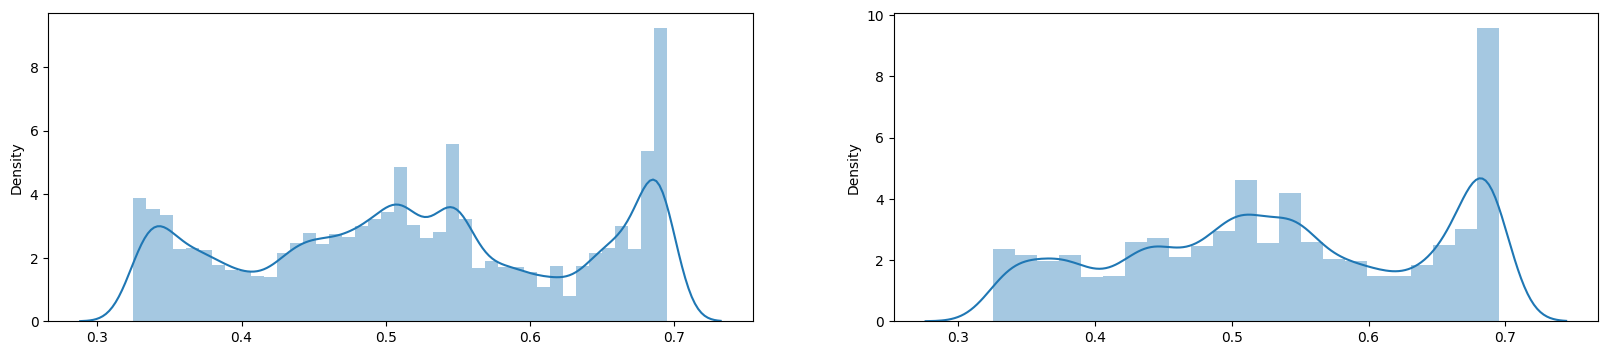

In [5]:
plt.figure(figsize=(20,4))
    
plt.subplot(1,2,1)
sns.distplot(pred_probs_train)

    
plt.subplot(1,2,2)
sns.distplot(pred_probs_test)


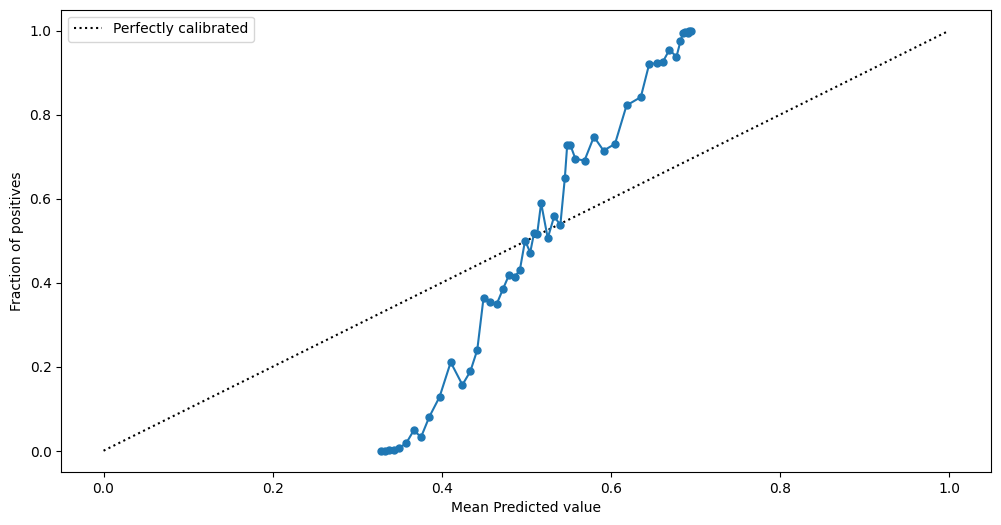

In [6]:
df_tmp = calibration_curve(y_train, pred_probs_train, n_bins=50, strategy='quantile')

plt.figure(figsize=(12, 6))
plt.plot([0, 1], [0, 1], 'k:', label="Perfectly calibrated")  

plt.plot(df_tmp[1], df_tmp[0], marker = '.', markersize = 10)
plt.legend()

plt.xlabel("Mean Predicted value")
plt.ylabel("Fraction of positives")
plt.show()

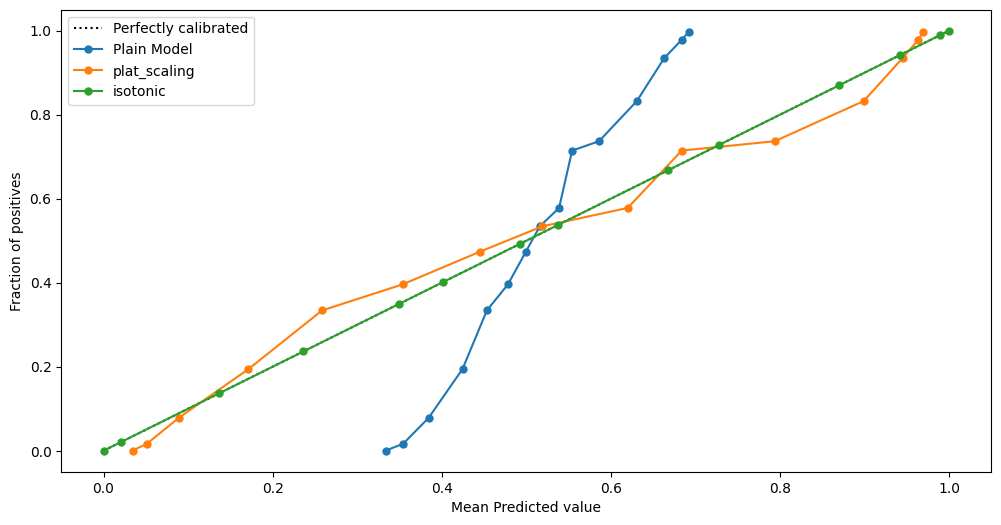

In [7]:
cal_clf_plat = CalibratedClassifierCV(model, method="sigmoid", cv="prefit")
cal_clf_plat.fit(X_train_scaled, y_train)
train_preds_cal_plat = cal_clf_plat.predict_proba(X_train_scaled)[:,1]


cal_clf_iso = CalibratedClassifierCV(model, method="isotonic", cv="prefit")
cal_clf_iso.fit(X_train_scaled, y_train)
train_preds_cal_iso = cal_clf_iso.predict_proba(X_train_scaled)[:,1]

df_tmp = calibration_curve(y_train, pred_probs_train, n_bins=15, strategy='quantile')
df_tmp2 = calibration_curve(y_train, train_preds_cal_plat, n_bins=15, strategy='quantile')
df_tmp3 = calibration_curve(y_train, train_preds_cal_iso, n_bins=15, strategy='quantile')

plt.figure(figsize=(12, 6))
plt.plot([0, 1], [0, 1], 'k:', label="Perfectly calibrated")  
plt.plot(df_tmp[1], df_tmp[0], marker = '.', markersize = 10, label = 'Plain Model')
plt.plot(df_tmp2[1], df_tmp2[0], marker = '.', markersize = 10, label = 'plat_scaling')
plt.plot(df_tmp3[1], df_tmp3[0], marker = '.', markersize = 10, label = 'isotonic')
plt.legend()
plt.xlabel("Mean Predicted value")
plt.ylabel("Fraction of positives")
plt.show()

### Probability Calibration of Test probas

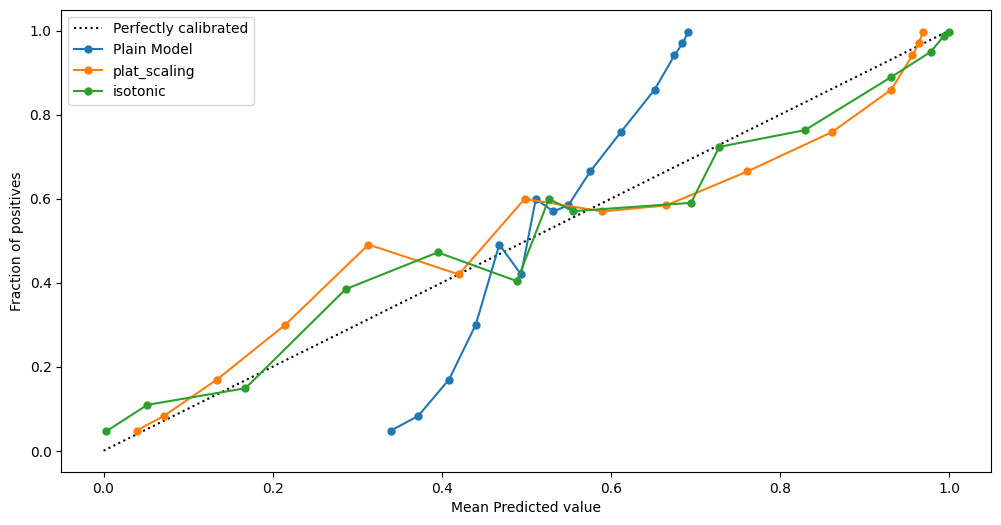

In [8]:
test_preds = model.predict_proba(X_test_scaled)[:,1]

test_preds_cal_plat = cal_clf_plat.predict_proba(X_test_scaled)[:,1]

test_preds_cal_iso = cal_clf_iso.predict_proba(X_test_scaled)[:,1]


df_tmp = calibration_curve(y_test, test_preds, n_bins=15, strategy='quantile')
df_tmp2 = calibration_curve(y_test,test_preds_cal_plat, n_bins=15, strategy='quantile')
df_tmp3 = calibration_curve(y_test,test_preds_cal_iso, n_bins=15, strategy='quantile')


plt.figure(figsize=(12, 6))
plt.plot([0, 1], [0, 1], 'k:', label="Perfectly calibrated") 
# plt.scatter(df_tmp[1], df_tmp[0],  label = 'model_logistic')
# plt.scatter(df_tmp2[1], df_tmp2[0],  label = 'plat_scaling')
# plt.scatter(df_tmp3[1], df_tmp3[0],  label = 'isotonic')
plt.plot(df_tmp[1], df_tmp[0], marker = '.', markersize = 10, label = 'Plain Model')
plt.plot(df_tmp2[1], df_tmp2[0], marker = '.', markersize = 10, label = 'plat_scaling')
plt.plot(df_tmp3[1], df_tmp3[0], marker = '.', markersize = 10, label = 'isotonic')
plt.legend()
plt.xlabel("Mean Predicted value")
plt.ylabel("Fraction of positives")
plt.show()

In [9]:
model.predict_proba(X_test_scaled[0].reshape(1,-1))[:,1]

array([0.65883035])

In [10]:
cal_clf_plat.predict_proba(X_test_scaled[0].reshape(1,-1))[:,1]

array([0.94078625])

<AxesSubplot: ylabel='Density'>

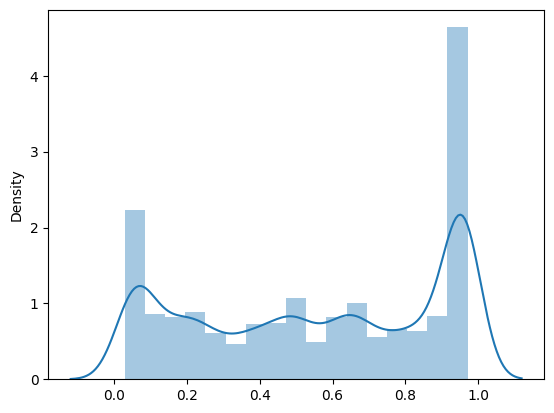

In [12]:
sns.distplot(cal_clf_plat.predict_proba(X_test_scaled)[:,1])

In [17]:
# exporting calibrator
cal = {
    'iso': cal_clf_iso,
    'plat': cal_clf_plat
}
with open("../models/calibrator/model2_gbdt_cal.pkl", "wb") as c:
    pickle.dump(cal, c)


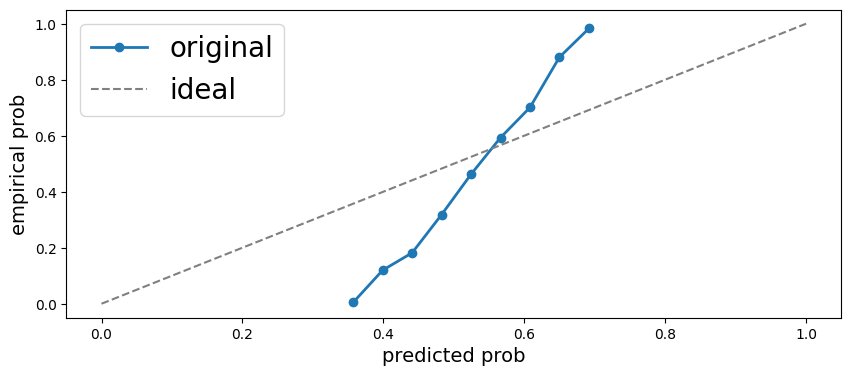

In [228]:
pred_probs = pred_probs_test

pred_probs_space = np.linspace(pred_probs.min(), pred_probs.max(), 10)

empirical_probs = []
pred_probs_midpoints = []

for i in range(len(pred_probs_space)-1):
    empirical_probs.append(
        np.mean(
            y_test[
                (pred_probs > pred_probs_space[i]) & (pred_probs < pred_probs_space[i+1])]
        )
    )
    pred_probs_midpoints.append(
        (pred_probs_space[i] + pred_probs_space[i+1])/2
    )

plt.figure(figsize=(10,4))
plt.plot(pred_probs_midpoints, empirical_probs, linewidth=2, marker='o')
plt.xlabel('predicted prob', fontsize=14)
plt.ylabel('empirical prob', fontsize=14)
    
plt.plot([0,1],[0,1],linestyle='--',color='gray')
    
plt.legend(['original', 'ideal'], fontsize=20)

In [229]:
pred_probs_test.reshape(-1,1)

array([[0.49403767],
       [0.49403767],
       [0.49403767],
       ...,
       [0.35526401],
       [0.35526401],
       [0.35469879]])

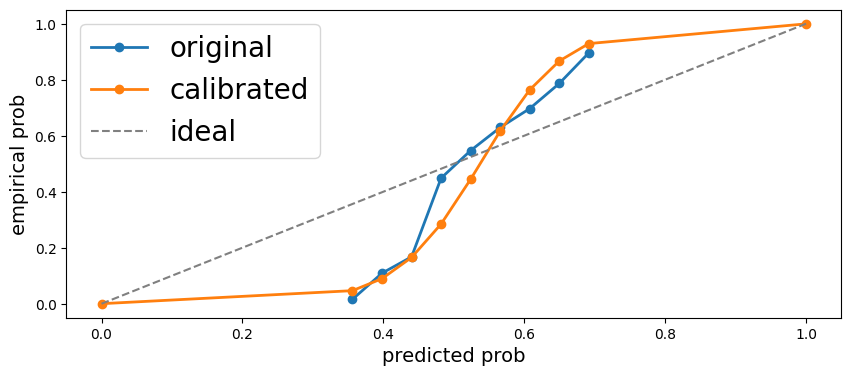

In [230]:
lr_model = LogisticRegression()
lr_model.fit(pred_probs_test.reshape(-1,1), y_test)

pred_probs = pred_probs_valid
pred_probs_space = np.linspace(pred_probs.min(), pred_probs.max(), 10)

empirical_probs = []
pred_probs_midpoints = []

for i in range(len(pred_probs_space)-1):
    empirical_probs.append(
        np.mean(
            y_val[(pred_probs > pred_probs_space[i]) & (pred_probs < pred_probs_space[i+1])]
        )
    )
    pred_probs_midpoints.append(
        (pred_probs_space[i] + pred_probs_space[i+1])/2
    )
    
calibrated_probs = lr_model.\
predict_proba(np.array([0.0] + pred_probs_midpoints + [1.0]).reshape(-1,1))[:,1]


plt.figure(figsize=(10,4))
plt.plot(pred_probs_midpoints, empirical_probs, linewidth=2, marker='o')
plt.xlabel('predicted prob', fontsize=14)
plt.ylabel('empirical prob', fontsize=14)
    
plt.plot([0.0]+pred_probs_midpoints+[1.0], calibrated_probs, linewidth=2, marker='o')
    
plt.plot([0,1],[0,1],linestyle='--',color='gray')
    
plt.legend(['original', 'calibrated', 'ideal'], fontsize=20)

<AxesSubplot: ylabel='Density'>

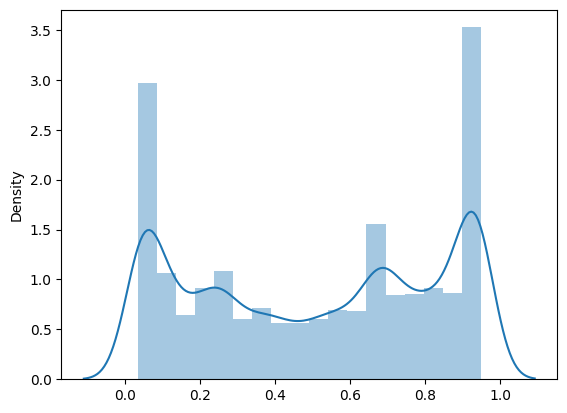

In [231]:
# lr_model.predict_proba(pred_probs_test.reshape(-1,1))[:,1]
sns.distplot(lr_model.predict_proba(pred_probs_test.reshape(-1,1))[:,1])

In [72]:
uncal = model.predict_proba(X_test_scaled[0].reshape(1,-1))[:,1]

In [73]:
uncal

array([0.59536279])

In [74]:
lr_model.predict_proba([uncal])[:,1]

array([0.61559639])